model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/10], Train Loss: 0.5126, Train Accuracy: 80.35%, Validation Loss: 0.1349, Validation Accuracy: 95.50%
Epoch [2/10], Train Loss: 0.1329, Train Accuracy: 95.00%, Validation Loss: 0.0695, Validation Accuracy: 97.20%
Epoch [3/10], Train Loss: 0.0811, Train Accuracy: 97.10%, Validation Loss: 0.2194, Validation Accuracy: 92.20%
Epoch [4/10], Train Loss: 0.0746, Train Accuracy: 97.80%, Validation Loss: 0.1320, Validation Accuracy: 96.10%
Epoch [5/10], Train Loss: 0.0398, Train Accuracy: 98.58%, Validation Loss: 0.0910, Validation Accuracy: 97.00%
Epoch [6/10], Train Loss: 0.0737, Train Accuracy: 97.60%, Validation Loss: 0.1077, Validation Accuracy: 96.30%
Epoch [7/10], Train Loss: 0.0643, Train Accuracy: 97.97%, Validation Loss: 0.1453, Validation Accuracy: 94.90%
Epoch [8/10], Train Loss: 0.0322, Train Accuracy: 98.92%, Validation Loss: 0.0843, Validation Accuracy: 97.40%
Epoch [9/10], Train Loss: 0.0313, Train Accuracy: 98.97%, Validation Loss: 0.0628, Validation Accuracy: 97.80%
E

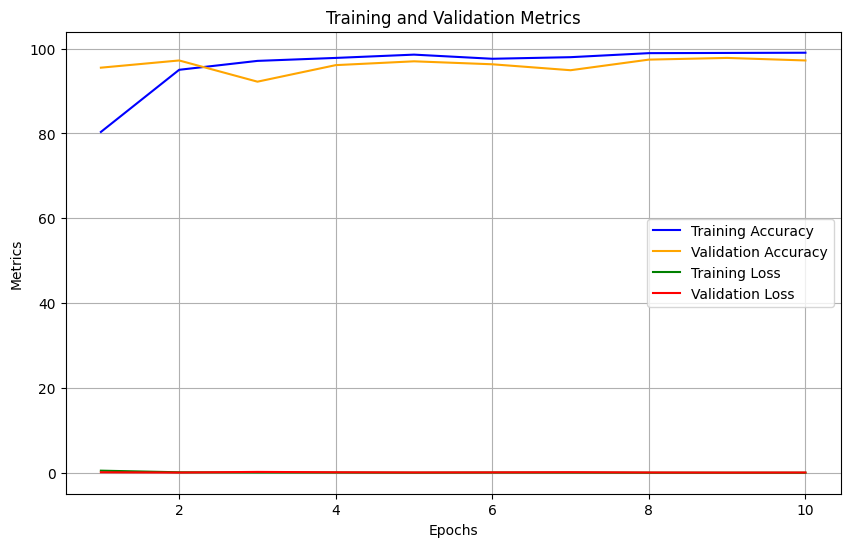

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Assuming your dataset is in folders trainset and testset
train_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/trainset', transform=train_transform)
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
model = create_model('vit_base_patch16_224', num_classes=10, pretrained=True).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_val_accuracy = 0.0  # Variable to track the best validation accuracy

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct / total
    train_loss /= len(train_loader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    val_accuracy = 100 * val_correct / val_total
    val_loss /= len(test_loader)

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.2f}%')

    # Save the model if the current validation accuracy is the best so far
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'vit_model_best.pth')

# Plotting accuracy and loss in a single plot
plt.figure(figsize=(10, 6))

# Plot training and validation accuracy
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', color='blue')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')

# Plot training and validation loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', color='green')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', color='red')

plt.title('Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
import torch
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Model evaluation mode
model.eval()

# Lists to store true labels and predicted labels
y_true = []
y_pred = []

# Iterate over the test dataset
for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    # Append true labels and predicted labels
    y_true.extend(labels.cpu().numpy())
    y_pred.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate precision, recall, and F1 score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.9799518287686539
Recall: 0.978
F1 Score: 0.9778918452754949


In [3]:
import torch
from timm import create_model

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model
model = create_model('vit_base_patch16_224', num_classes=10, pretrained=True).to(device)

# Calculate number of parameters in millions
total_params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Total number of parameters: {total_params:.2f} million")


Total number of parameters: 85.81 million


Confusion Matrix:
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.97 0.   0.   0.   0.03 0.   0.   0.  ]
 [0.   0.   0.   0.83 0.   0.17 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.02 0.   0.98 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.  ]]


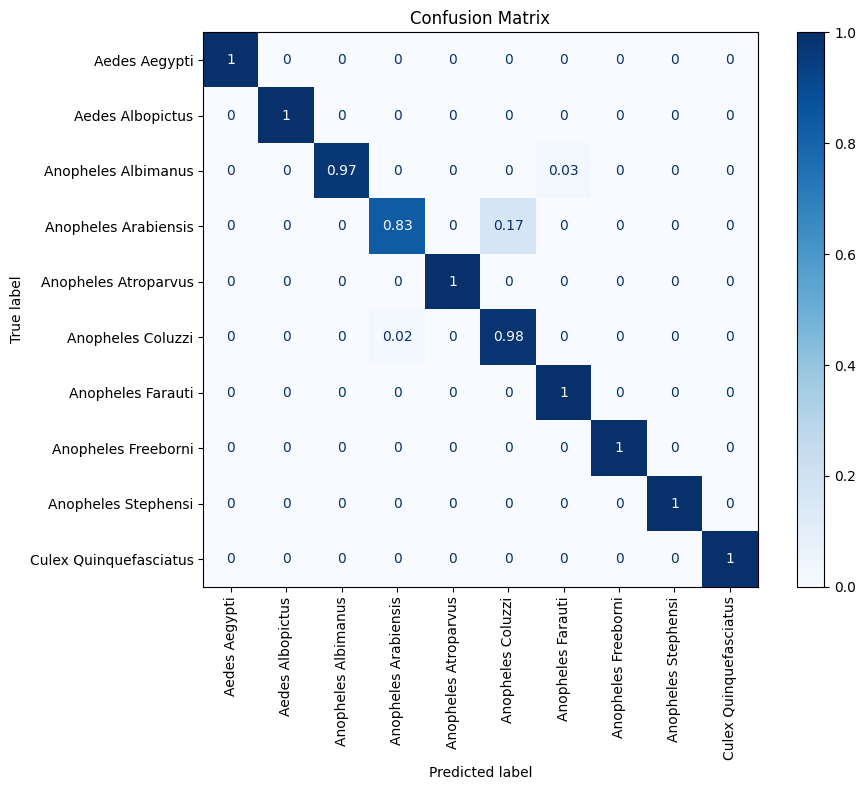

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data preprocessing
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Assuming your dataset is in folders trainset and testset
test_dataset = datasets.ImageFolder('/kaggle/input/datasetmosquito/dataset/dataset/testset', transform=test_transform)

# Data loader for the test set
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model
model = create_model('vit_base_patch16_224', num_classes=10, pretrained=True).to(device)
model.load_state_dict(torch.load('/kaggle/working/vit_model_best.pth', map_location=device))
model.eval()

# Define class names manually
class_names = ['Aedes Aegypti', 'Aedes Albopictus', 'Anopheles Albimanus',
               'Anopheles Arabiensis', 'Anopheles Atroparvus', 'Anopheles Coluzzi',
               'Anopheles Farauti', 'Anopheles Freeborni', 'Anopheles Stephensi',
               'Culex Quinquefasciatus']

# Get the true labels and predictions for the test set
val_true_labels = []
val_predictions = []

for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    val_true_labels.extend(labels.cpu().numpy())
    val_predictions.extend(predicted.cpu().numpy())

# Create the confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions, normalize='true')

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()
